# Data Curation
Curating raw data is a long, detailed process that takes several steps.
SMILES strings need to be standardized, meaurements in different units 
need to be converted to a common unit, outliers need to be removed, 
and duplicates need to be combined. These steps are vital to good data science. 
Here we will cover some tools in AMPL that are used to perform these 
steps.

- `base_smiles_from_smiles`
- `standardize_relations`
- `convert_IC50_to_pIC50`
- `remove_outlier_replicates`
- `aggregate_assay_data`

These are just a few of the steps needed to curate a dataset;
another tutorial will cover data curation in more detail.

## Read the data.
We've prepared an example dataset containing IC50 values for the KCNA5 target
collected from [ChEMBL](https://www.ebi.ac.uk/chembl/). This dataset is 
simpler than what is commonly found in the wild, but will concisely 
demonstrate AMPL tools.

In [66]:
import pandas as pd
import numpy as np
import sklearn as sns

# read in data
kcna5=pd.read_csv('dataset/kcna5_ic50.csv')

## Columns
This dataset is drawn from the ChEMBL database and contains the following columns
- `molecule_chembl_id`: The ChEMBL id for the molecule.
- `smiles`: The SMILES string that represents the molecule. This is the main
input taken by AMPL models.
- `standard_type`: This column records the type of endpoint e.g., IC50, Ki, Kd, etc.
This dataset only contains IC50 data points.
- `standard_relation`: Data points might be censored. This column records if the 
datapoint is censored or not.
- `standard_value`: The IC50 value is recorded here.
- `standard_units`: IC50 values can be recorded in different units which are recorded
here. Fortunately, all of this data uses nM.

In [67]:
kcna5.shape

(880, 6)

In [68]:
kcna5.columns

Index(['molecule_chembl_id', 'smiles', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units'],
      dtype='object')

## Standardize SMILES
SMILES strings are not unique and the same compound can be represented by different, 
not so equivalent, SMILES. This step simplifies the machine learning problem by 
ensuring each compound is represented the same way. **Beware!** The input
to base_smiles_from_smiles must be a `list`.

In [69]:
from atomsci.ddm.utils.struct_utils import base_smiles_from_smiles
kcna5['base_rdkit_smiles'] = base_smiles_from_smiles(kcna5.smiles.tolist())

In [70]:
kcna5.smiles.nunique(), kcna5.base_rdkit_smiles.nunique()

(802, 802)

Note that there are 802 unique SMILES from Chembl that are standardized to 802 unique smiles; sometimes two SMILES are standardized to the same thing. From now on we will use `base_rdkit_smiles`.

## Standardize Relations
Relations can also differ from database to database. This function will standardize the relation column for use with AMPL. Since this data is from ChEMBL, we will call 
the function with `db='ChEMBL'`

In [71]:
from atomsci.ddm.utils.data_curation_functions import standardize_relations
kcna5 = standardize_relations(kcna5, db='ChEMBL', 
                    rel_col='standard_relation',
                    output_rel_col='fixed_relation')

In [72]:
kcna5.standard_relation.value_counts()

standard_relation
'='    804
'>'     74
'~'      2
Name: count, dtype: int64

In [73]:
kcna5.fixed_relation.value_counts()

fixed_relation
=    806
>     74
Name: count, dtype: int64

## Calculate pIC50s
We will convert the IC50s to pIC50s before performing machine learning. This function 
will use `standard_units` and `standard_value` columns. This function converts IC50s 
in nM to pIC50s.

In [74]:
from atomsci.ddm.utils.data_curation_functions import convert_IC50_to_pIC50
kcna5 = convert_IC50_to_pIC50(kcna5, 
                              unit_col='standard_units',
                              value_col='standard_value',
                              new_value_col='pIC50',
                              unit_conv={'µM':lambda x: x*1e-6, 'nM':lambda x: x*1e-9},
                              inplace=False)

array([[<Axes: title={'center': 'standard_value'}>,
        <Axes: title={'center': 'pIC50'}>]], dtype=object)

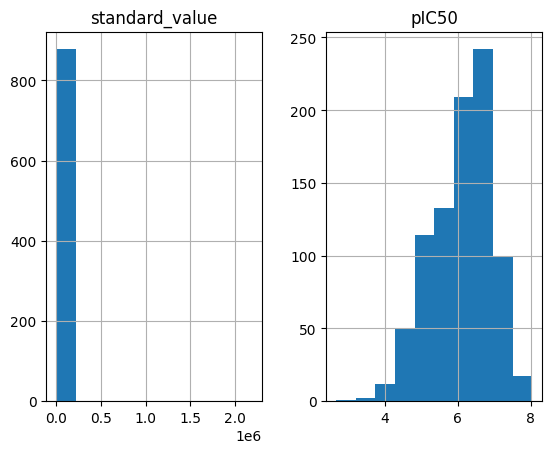

In [75]:
kcna5[['standard_value', 'pIC50']].hist()

## Remove outliers and aggregate
The final step is to remove outliers and aggregate duplicate measurements. 


In [76]:
from atomsci.ddm.utils.curate_data import remove_outlier_replicates, aggregate_assay_data

kcna5_cur = remove_outlier_replicates(kcna5, id_col='molecule_chembl_id',
                                response_col='pIC50')

kcna5_cur = aggregate_assay_data(kcna5_cur, 
                             value_col='pIC50',
                             output_value_col='avg_pIC50',
                             id_col='molecule_chembl_id',
                             smiles_col='base_rdkit_smiles',
                             relation_col='fixed_relation',
                             label_actives=False,
                             verbose=True
                        )

kcna5_cur.to_csv('dataset/curated_kcna5_ic50.csv', index=False)

Removed 1 pIC50 replicate measurements that were > 1.0 from median
0 entries in input table are missing SMILES strings
802 unique SMILES strings are reduced to 802 unique base SMILES strings


> **Beware!** `aggregate_assay_data` changes `molecule_chembl_id` to `compound_id`,
`fixed_relation` to `relation`, and will create the value column `avg_pIC50`.
The column `active` is added but is not used in this tutorial. It will be covered
in a classification tutorial.

In [77]:
kcna5.shape, kcna5_cur.shape

((880, 9), (802, 4))

In [78]:
kcna5.columns

Index(['molecule_chembl_id', 'smiles', 'standard_type', 'standard_relation',
       'standard_value', 'standard_units', 'base_rdkit_smiles',
       'fixed_relation', 'pIC50'],
      dtype='object')

In [79]:
kcna5_cur.columns

Index(['compound_id', 'base_rdkit_smiles', 'relation', 'avg_pIC50'], dtype='object')

All together, the curation process looks like this. We use this
function to curate two more datasets for related targets.

In [80]:
import os

def curate(df):
     df['base_rdkit_smiles'] = base_smiles_from_smiles(df.smiles.tolist())

     df = standardize_relations(df, db='ChEMBL', 
                    rel_col='standard_relation',
                    output_rel_col='fixed_relation')

     df = convert_IC50_to_pIC50(df, 
                              unit_col='standard_units',
                              value_col='standard_value',
                              new_value_col='pIC50',
                              unit_conv={'µM':lambda x: x*1e-6, 'nM':lambda x: x*1e-9},
                              inplace=False)

     df = remove_outlier_replicates(df, id_col='molecule_chembl_id',
                                   response_col='pIC50')

     df = aggregate_assay_data(df, 
                              value_col='pIC50',
                              output_value_col='avg_pIC50',
                              id_col='molecule_chembl_id',
                              smiles_col='base_rdkit_smiles',
                              relation_col='fixed_relation',
                              label_actives=False
                         )
     return df

for f in ['kcna3_ic50.csv', 'scn5a_ic50.csv']:
     print(f'{f}\n')
     df = pd.read_csv(os.path.join('dataset', f))
     print("Original data shape: ", df.shape)
     df = curate(df)
     print("Curated data shape: ", df.shape)
     print(df.columns, '\n')
     df.to_csv('dataset/curated_'+f, index=False)

kcna3_ic50.csv

Original data shape:  (891, 6)
Removed 19 pIC50 replicate measurements that were > 1.0 from median
Curated data shape:  (514, 4)
Index(['compound_id', 'base_rdkit_smiles', 'relation', 'avg_pIC50'], dtype='object') 

scn5a_ic50.csv

Original data shape:  (2368, 6)
Removed 20 pIC50 replicate measurements that were > 1.0 from median
Curated data shape:  (2036, 4)
Index(['compound_id', 'base_rdkit_smiles', 'relation', 'avg_pIC50'], dtype='object') 



## Multi-task data

Now that the data is curated we can combine it with 2 other datasets that are already curated.

In [82]:
kcna5 = pd.read_csv('dataset/curated_kcna5_ic50.csv')
kcna3 = pd.read_csv('dataset/curated_kcna3_ic50.csv')
scn5a = pd.read_csv('dataset/curated_scn5a_ic50.csv')

df=kcna5.merge(kcna3, how='outer', on=['compound_id', 'base_rdkit_smiles',], suffixes=['_kcna5','_kcna3'])
scn5a.columns=['compound_id', 'base_rdkit_smiles', 'relation_scn5a', 'avg_pIC50_scn5a']
df = df.merge(scn5a, how='outer', on=['compound_id', 'base_rdkit_smiles'])
print(df.columns)
df.to_csv('dataset/kcna5_kcna3_scna5a.csv', index=False)

Index(['compound_id', 'base_rdkit_smiles', 'relation_kcna5', 'avg_pIC50_kcna5',
       'relation_kcna3', 'avg_pIC50_kcna3', 'relation_scn5a',
       'avg_pIC50_scn5a'],
      dtype='object')


In [83]:
df.head()

,compound_id,base_rdkit_smiles,relation_kcna5,avg_pIC50_kcna5,relation_kcna3,avg_pIC50_kcna3,relation_scn5a,avg_pIC50_scn5a
0,CHEMBL3127405,NC(=O)c1ccc(N(Cc2ccc(F)cc2)S(=O)(=O)c2ccccc2F)cc1,NaN,5.657577,NaN,NaN,NaN,NaN
1,CHEMBL1289071,CC(C)(CNC(=O)c1cc[nH]c1)CN(C1=NS(=O)(=O)c2cc(F...,NaN,5.879426,NaN,5.939302,NaN,NaN
2,CHEMBL2312933,CCCN(c1cccnc1)P(=O)(c1ccccc1)c1ccccc1,NaN,6.920819,NaN,NaN,NaN,NaN
3,CHEMBL4100226,CN(C)C(=O)c1cccc(-c2ccccc2CC(c2cccnc2)c2cccnc2)c1,NaN,7.193820,NaN,NaN,NaN,NaN
4,CHEMBL1090794,OC(c1cccnc1)(c1cccnc1)C(c1ccccc1)N1CCOCC1,NaN,6.591760,NaN,NaN,NaN,NaN


This plot shows there are not many SMILES that overlap between the three targets.

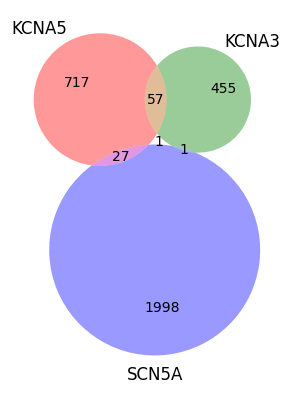

In [84]:
import matplotlib_venn as mpv
mpv.venn3([set(df.loc[~df.avg_pIC50_kcna5.isna(), 'base_rdkit_smiles']),
           set(df.loc[~df.avg_pIC50_kcna3.isna(), 'base_rdkit_smiles']),
           set(df.loc[~df.avg_pIC50_scn5a.isna(), 'base_rdkit_smiles']),],
          set_labels=['KCNA5','KCNA3','SCN5A'])